## Definição do problema:

Neste desafio voê deverá descobrir quais estudantes estão fazendo a prova do ENEM 2016 apenas para treino.

## Bibliotecas

In [1]:
import pycaret
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
from imblearn.over_sampling import SMOTE
from pycaret.classification import *

## Configurações

In [2]:
# Definindo o estilo e o tamanho dos gráficos:
pylab.rcParams['figure.figsize'] = (6, 4)
plt.style.use('fivethirtyeight')

## Dados

In [3]:
# Dados de treino:
df_train = pd.read_csv('train.csv')
# Dados de teste:
df_test = pd.read_csv('test.csv')

# Criando o dataframe de resposta:
answer = pd.DataFrame()

## Análise Exploratória

In [4]:
# Guardando o número da inscrição:
answer['NU_INSCRICAO'] = df_test['NU_INSCRICAO']

In [5]:
# Removendo o número de inscrição de ambos dataframes:
df_train.drop(['NU_INSCRICAO'], axis=1, inplace=True)
df_test.drop(['NU_INSCRICAO'],axis=1, inplace=True)

In [6]:
# Número de linhas e colunas:
df_train.shape, df_test.shape

((13730, 166), (4570, 42))

In [7]:
# Verificando o shape dos conjuntos de dados podemos observar que temos mais colunas no dados de treino no que nos dados de teste, então usaremos somente as features que existe no dataframe de test para analisarmos e determinar quais as features devemos utilizar para fazer a predição.

cols = list(df_test)
cols.append('IN_TREINEIRO')

train = df_train[cols]
test = df_test

In [8]:
# Visualizando os dados de treino:
train.head()

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,IN_TREINEIRO
0,43,RS,24,M,1,1,1,4,1,NaN,...,520.0,D,D,C,A,A,C,H,A,0
1,23,CE,17,F,3,1,2,0,2,1.0,...,580.0,A,A,B,A,A,A,NaN,A,0
2,23,CE,21,F,3,1,3,0,1,NaN,...,NaN,D,D,C,A,A,A,NaN,A,0
3,33,RJ,25,F,0,1,1,9,1,NaN,...,NaN,H,E,E,C,B,C,F,D,0
4,13,AM,28,M,2,1,1,4,1,NaN,...,NaN,E,D,C,A,A,B,F,A,0


In [9]:
# Visualizando os dados de teste:
test.head()

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,43,RS,19,F,1,1,1,3,1,NaN,...,NaN,NaN,E,E,H,B,B,C,D,A
1,15,PA,24,M,3,2,1,4,1,NaN,...,NaN,NaN,B,C,B,A,A,C,D,A
2,29,BA,16,F,2,1,3,0,1,NaN,...,NaN,NaN,E,F,G,B,B,A,NaN,D
3,41,PR,17,F,1,1,2,0,2,1.0,...,40.0,480.0,E,E,E,C,B,B,C,A
4,53,DF,19,F,1,1,1,1,1,NaN,...,80.0,720.0,E,E,E,B,B,B,D,A


- Selecionando as features que fazem sentido para o modelo com base no [dicionário de dados](https://s3-us-west-1.amazonaws.com/acceleration-assets-highway/data-science/dicionario-de-dados.zip).

In [10]:
train = train[['NU_IDADE','TP_ST_CONCLUSAO','IN_TREINEIRO']]
test = test[['NU_IDADE','TP_ST_CONCLUSAO']]

### **Observação:** Os estudantes classificados como treineiros são aqueles que optam por fazer as provas mesmo sem ter concluido o ensino médio.

## Análise detalhada da variável alvo "IN_TREINEIRO"

In [11]:
# Visualizando a distribuição das classes:
train['IN_TREINEIRO'].value_counts()

0    11947
1     1783
Name: IN_TREINEIRO, dtype: int64

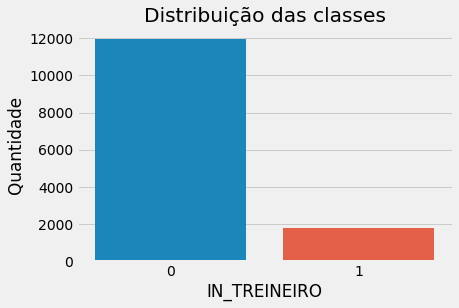

In [12]:
# Plot:
ax = sns.countplot(x='IN_TREINEIRO', data=train)
plt.ylabel('Quantidade')
plt.title('Distribuição das classes');

- Como podemos observar temos uma base desbalanceada, ou seja, o dataset possui muitos exemplos da classe 0 e poucos exemplos da classe 1.

- Precisamos corrigir esse problema para que o modelo não classifique os novos dados como sendo da classe que possui mais exemplos.

## Usando o método **SMOTE** (Synthetic Minority Over-sampling Technique)  para lidar com os dados desbalanceados.

Esse método gera dados sintéticos (não duplicados) da classe minoritária a partir de vizinhos. Ele calcula quais são os vizinhos mais próximos e as características desses vizinhos para criar novos dados. Se o número de dados gerados for muito grande podemos ter um overfiting.

In [13]:
# Instanciando o SMOTE:
smt = SMOTE()

In [14]:
# Separando a classe (variável que queremos prever):
target = train['IN_TREINEIRO']
type(target)

pandas.core.series.Series

- Essa técnica possui o parâmetro sampling_strategy que nos permiti definir qual a porcentagem de dados sintéticos que queremos. Se definirmos 0.5 por exemplo, ele vai gerar dados sintéticos até 50% da classe majoritária, mas vou optar por usar o método padrão mesmo.

In [15]:
# Aplicando o SMOTE nos dados:
train, target = smt.fit_sample(train, target)

In [16]:
# Visualizando novamente a distribuição das classes:
np.bincount(target)

array([11947, 11947])

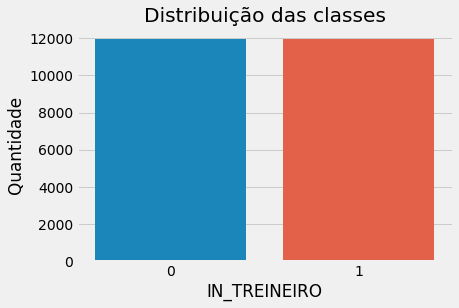

In [17]:
# Plot:
ax = sns.countplot(x=target)
plt.ylabel('Quantidade')
plt.title('Distribuição das classes');

- Os dados agora estão balanceados, temos cerca de 11947 registros para cada classe.

In [18]:
# Transformando a Series em um dataframe:
target = pd.DataFrame({'IN_TREINEIRO':target.values})

In [19]:
# Verificando os dados depois das transformações:

In [20]:
train.head()

,NU_IDADE,TP_ST_CONCLUSAO,IN_TREINEIRO
0,24,1,0
1,17,2,0
2,21,3,0
3,25,1,0
4,28,1,0


In [21]:
test.head()

,NU_IDADE,TP_ST_CONCLUSAO
0,19,1
1,24,1
2,16,3
3,17,2
4,19,1


## Breve introdução sobre o **Pycaret**:

Para testar o desempenho de vários modelos optei por usar a biblioteca pycaret que agiliza e facilita todo o processo de machine learning desde o pipeline até a implementação do modelo.
Todas as informações descritas daqui em diante foram baseadas na [documentação](https://pycaret.org/guide/).

## **1-**Explicação dos parâmetros que serão setados a seguir:

- **data:** dados de treino.

- **target:** variável alvo.

- **session_id:** equivalente ao seed do sklearn que garante a reprodutibilidade do experimento.

In [22]:
pipeline = setup(data=train, target='IN_TREINEIRO',session_id=1991)


Setup Succesfully Completed!


,Description,Value
0,session_id,1991
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(23894, 3)"
4,Missing Values,False
5,Numeric Features,1
6,Categorical Features,1
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


- O setup inicializa o ambiente pycaret e os parâmetros são usados para criar todo o pipeline de transformação dos dados. Outro detalhe é que ele infere automaticamente os tipos de dados, mas para garantir que eles sejam identificados corretamente podemos usar os parâmetros numeric_features e categorical_features.

Você pode usar o **compare_models()** para avaliar e decidir qual o modelo que tem os melhores resultados com base nas métricas, como temos poucas colunas tomei a decisão de pular esse passo e já partir para a criação do modelo.

## **2-**Instanciando o modelo 	Decision Tree Classifier:

- Precisamos passar o nome do modelo de forma abreviada no formato de string conforme descrito na documentação. Para mais detalhes acesse https://pycaret.org/create-model/.

In [23]:
clf = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9940,0.9999,1.0,0.9882,0.9941,0.9880
1,0.9940,0.9998,1.0,0.9882,0.9941,0.9880
2,0.9910,0.9999,1.0,0.9824,0.9911,0.9821
3,0.9898,0.9998,1.0,0.9801,0.9899,0.9797
4,0.9874,0.9998,1.0,0.9755,0.9876,0.9749
5,0.9958,0.9999,1.0,0.9917,0.9958,0.9916
6,0.9904,0.9998,1.0,0.9812,0.9905,0.9809
7,0.9910,0.9998,1.0,0.9824,0.9911,0.9821
8,0.9910,0.9998,1.0,0.9824,0.9911,0.9821
9,0.9898,0.9998,1.0,0.9801,0.9899,0.9797


- Por padrão essa função treina o modelo e o classifica usando a validação cruzada k-fold(10 por padrão), e retorna as pontuações das principais métricas usadas para avaliar os modelos de classificação.

In [24]:
# Verificando o resultado final após a validação cruzada:
predict_model(clf);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Decision Tree Classifier,0.9912,0.9998,1.0,0.9827,0.9913,0.9824


## **3-**Fazendo as predições

In [25]:
# A função predict_model() é usada para prever os valores nos dados de teste:
predictions = predict_model(clf, data = test)

## **4-**Gráficos para a análise dos resultados

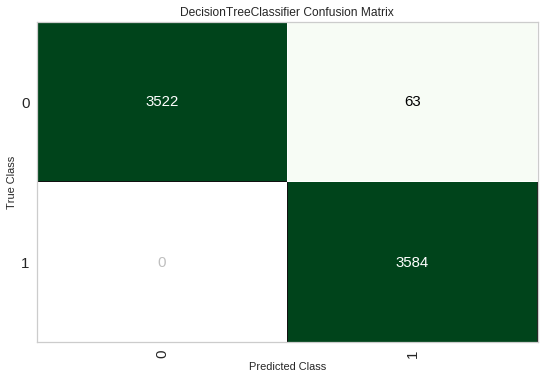

In [26]:
#  Confusion Matrix
plot_model(estimator = clf, plot = 'confusion_matrix')

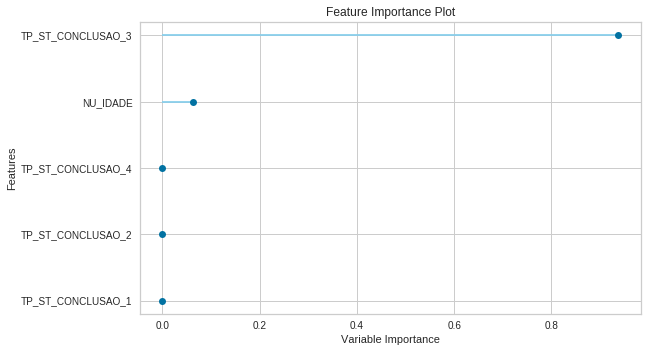

In [27]:
# Feature Importance
plot_model(estimator = clf, plot = 'feature')

## **5-**Visualizando os resultados

In [28]:
answer = pd.DataFrame({'NU_INSCRICAO':  answer['NU_INSCRICAO'],  'IN_TREINEIRO':predictions['Label']})
answer.sample(10)

,NU_INSCRICAO,IN_TREINEIRO
2800,ef46a1ee19ddc1e21e46531ead955127bce6df3d,1
3143,d7911891c0333223e067036ec9dad1a4b36814be,0
3667,5b636f456f72983b906eabb958636953c44c4758,0
1081,964d630e6102f9949ffee98079e695bf44a78132,0
4118,f23765837038df23560da715edbeb2105df9bc42,0
3222,26386367f426036c638a4886d8727b4461ad1eb6,0
3870,15d1dc729eefa168415e0908aad14587dcbbf427,0
298,e522d2a68f167e3ec38a86a94a6cc4ef7eb30706,0
2147,702df94b9e082aa706f99bd6ce8ba93d235ac204,0
1014,0ba268f58810d597f149a7e4cfa97ad5ebf05423,0


## **6-**Salvando os resultados

In [29]:
answer.to_csv('answer.csv',index=False,header=True)

O score na plataforma da codenation foi de **98,73**.